## Problem 1

Using cla_brown, mean = 150.00, std = 0.60
Using arith, mean = 149.00, std = 91.19
Using geo_brown, mean = 179.08, std = 116.14


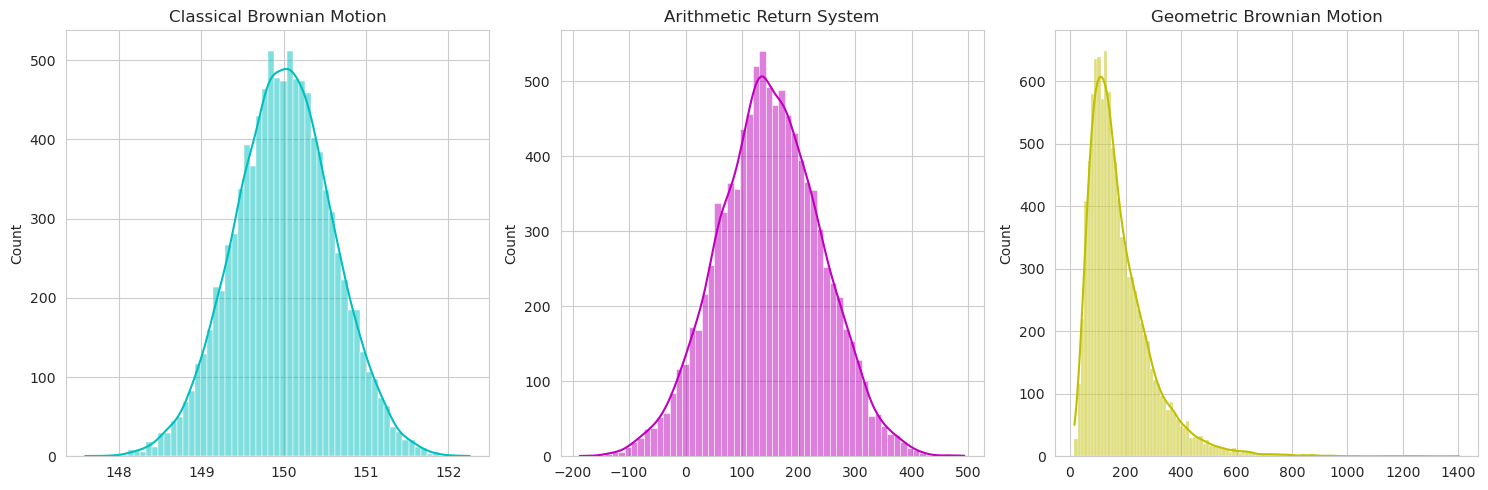

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t, norm, normaltest
from statsmodels.tsa.arima.model import ARIMA

sns.set_style("whitegrid")
sns.set_palette("husl")

# Helper Functions

def simulate_price(method, P0, std, N):
    r = np.random.normal(0, std, N)
    
    if method == "cla_brown":
        return P0 + r
    elif method == "arith":
        return P0 * (1+r)
    elif method == "geo_brown":
        return P0 * np.exp(r)
    else:
        raise ValueError("Invalid method!")

# Parameters
P0 = 150
std = 0.6
N = 10000

# Simulate Prices
methods = ["cla_brown", "arith", "geo_brown"]
results = {method: simulate_price(method, P0, std, N) for method in methods}

# Display Results
for method, prices in results.items():
    print(f"Using {method}, mean = {np.mean(prices):.2f}, std = {np.std(prices):.2f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(results['cla_brown'], ax=axes[0], kde=True, color="c")
sns.histplot(results['arith'], ax=axes[1], kde=True, color="m")
sns.histplot(results['geo_brown'], ax=axes[2], kde=True, color="y")
axes[0].set_title("Classical Brownian Motion")
axes[1].set_title("Arithmetic Return System")
axes[2].set_title("Geometric Brownian Motion")
plt.tight_layout()
plt.show()

## Problem 2

In [20]:
import warnings
warnings.filterwarnings('ignore')
def return_calculate(prices: pd.DataFrame, method="ARITHMETIC", dateColumn="Date") -> pd.DataFrame:
    vars = [col for col in prices.columns if col != dateColumn]
    
    # Calculate returns
    p = prices[vars].values
    p2 = p[1:] / p[:-1]
    
    if method.upper() == "ARITHMETIC":
        p2 = p2 - 1.0
    elif method.upper() == "LOG":
        p2 = np.log(p2)
    else:
        raise ValueError(f"method: {method} must be in ('LOG','ARITHMETIC')")
    
    out = pd.DataFrame({dateColumn: prices[dateColumn].iloc[1:].values})
    for var, col in zip(vars, p2.T):
        out[var] = col
    return out

# Testing the return_calculate function
price_df = pd.read_csv('DailyPrices.csv')
returns = return_calculate(price_df)
META_ret = returns['META']

# Adjusting mean of META returns to 0
META_ret0 = META_ret - META_ret.mean()

META_ret0.head()

0   -0.033266
1   -0.013890
2    0.008882
3    0.007625
4    0.040962
Name: META, dtype: float64

In [21]:
from statsmodels.tsa.arima.model import ARIMA

# VaR using a normal distribution
def norml_var(returns, alpha=0.05, N=10000):
    mean, std = returns.mean(), returns.std()
    Rt = np.random.normal(mean, std, N)
    Rt.sort()
    var = -Rt[int(alpha * N)]
    return var, Rt

# VaR using a normal distribution with an Exponentially Weighted variance
def norml_ew_var(returns, alpha=0.05, N=10000, w_lambda=0.94):
    mean = returns.mean()
    std = np.sqrt(exp_w_variance(returns))
    Rt = np.random.normal(mean, std, N)
    Rt.sort()
    var = -Rt[int(alpha * N)]
    return var, Rt

def norml_ew_var(returns, alpha = 0.05, N = 10000):
        mean = returns.mean()
        std = np.sqrt(exp_w_variance(returns))
        Rt = np.random.normal(mean, std, N)
        Rt.sort()
        var = Rt[int(alpha * len(Rt))] * (-1)
        #print(-np.percentile(returns, alpha*100))
        return var, Rt

# VaR using a MLE fitted T distribution
def MLE_T_var(returns, alpha=0.05, N=10000):
    df, loc, scale = t.fit(returns)
    Rt = t(df, loc, scale).rvs(N)
    Rt.sort()
    var = -Rt[int(alpha * N)]
    return var, Rt

# VaR using a fitted AR(1) model
def ar1_var(returns, alpha=0.05, N=10000):
    model = ARIMA(returns, order=(1, 0, 0))
    result = model.fit()
    predicted_mean = result.forecast(steps=1).values[0]
    resid_std = np.std(result.resid)
    Rt = predicted_mean + np.random.normal(0, resid_std, N)
    Rt.sort()
    var = -Rt[int(alpha * N)]
    return var, Rt

# VaR using a historic simulation
def his_var(returns, alpha=0.05):
    Rt = returns.sort_values().values
    var = -Rt[int(alpha * len(Rt))]
    return var, Rt

# Calculating VaR for different methods
var_nor, Rt_nor = norml_var(META_ret0)
var_ew, Rt_ew = norml_ew_var(META_ret0)
var_T, Rt_T = MLE_T_var(META_ret0)
var_ar1, Rt_ar1 = ar1_var(META_ret0)
var_his, Rt_his = his_var(META_ret0)

var_values = {
    "Normal Distribution": var_nor,
    "Exponentially Weighted Variance": var_ew,
    "MLE fitted T Distribution": var_T,
    "AR(1) Model": var_ar1,
    "Historic Simulation": var_his
}

var_values

{'Normal Distribution': 0.054707265915804694,
 'Exponentially Weighted Variance': 0.030719253464518263,
 'MLE fitted T Distribution': 0.04192166631600979,
 'AR(1) Model': 0.05395185599442447,
 'Historic Simulation': 0.0395076854830965}

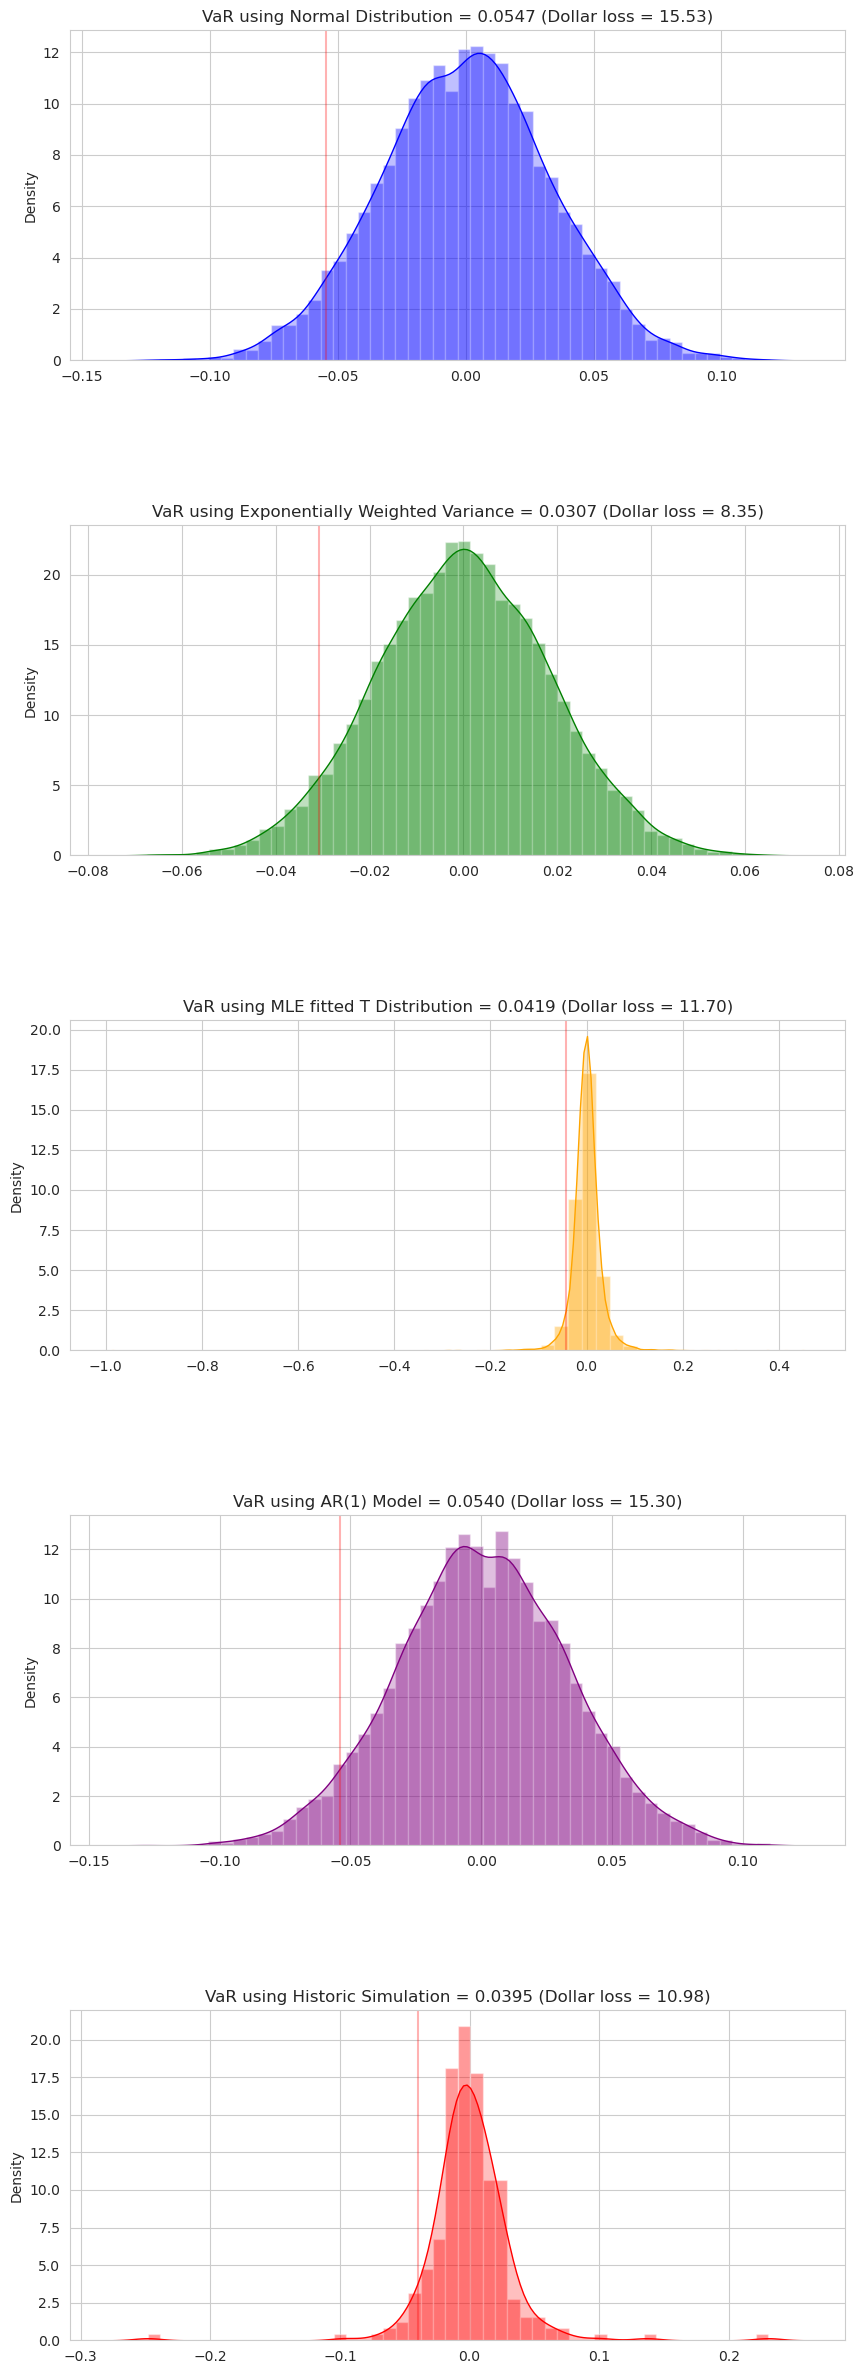

{'Normal Distribution': 15.528271676723222,
 'Exponentially Weighted Variance': 8.353937224636637,
 'MLE fitted T Distribution': 11.704354714629357,
 'AR(1) Model': 15.302343687257153,
 'Historic Simulation': 10.9823813585034}

In [22]:
# Convert VaR to dollar loss
def ret_to_dollar(ret_var, return_s, price_s):
    dollar_var = (ret_var - return_s.mean()) * price_s.values[-1]
    return dollar_var

# VaR in dollar loss for different methods
var_dollar_values = {
    method: ret_to_dollar(value, META_ret, price_df['META'])
    for method, value in var_values.items()
}

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distributions
fig, axes = plt.subplots(5, 1, figsize=(10, 30))

sns.distplot(Rt_nor, ax=axes[0], color='blue', kde_kws={"shade": True})
sns.distplot(Rt_ew, ax=axes[1], color='green', kde_kws={"shade": True})
sns.distplot(Rt_T, ax=axes[2], color='orange', kde_kws={"shade": True})
sns.distplot(Rt_ar1, ax=axes[3], color='purple', kde_kws={"shade": True})
sns.distplot(Rt_his, ax=axes[4], color='red', kde_kws={"shade": True})

methods = list(var_values.keys())
for ax, method, var in zip(axes, methods, var_values.values()):
    ax.axvline(x=-var, color='red', alpha=0.3)
    ax.set_title(f"VaR using {method} = {var:.4f} (Dollar loss = {var_dollar_values[method]:.2f})")

plt.subplots_adjust(hspace=0.5)
plt.show()

var_dollar_values

## Problem 3

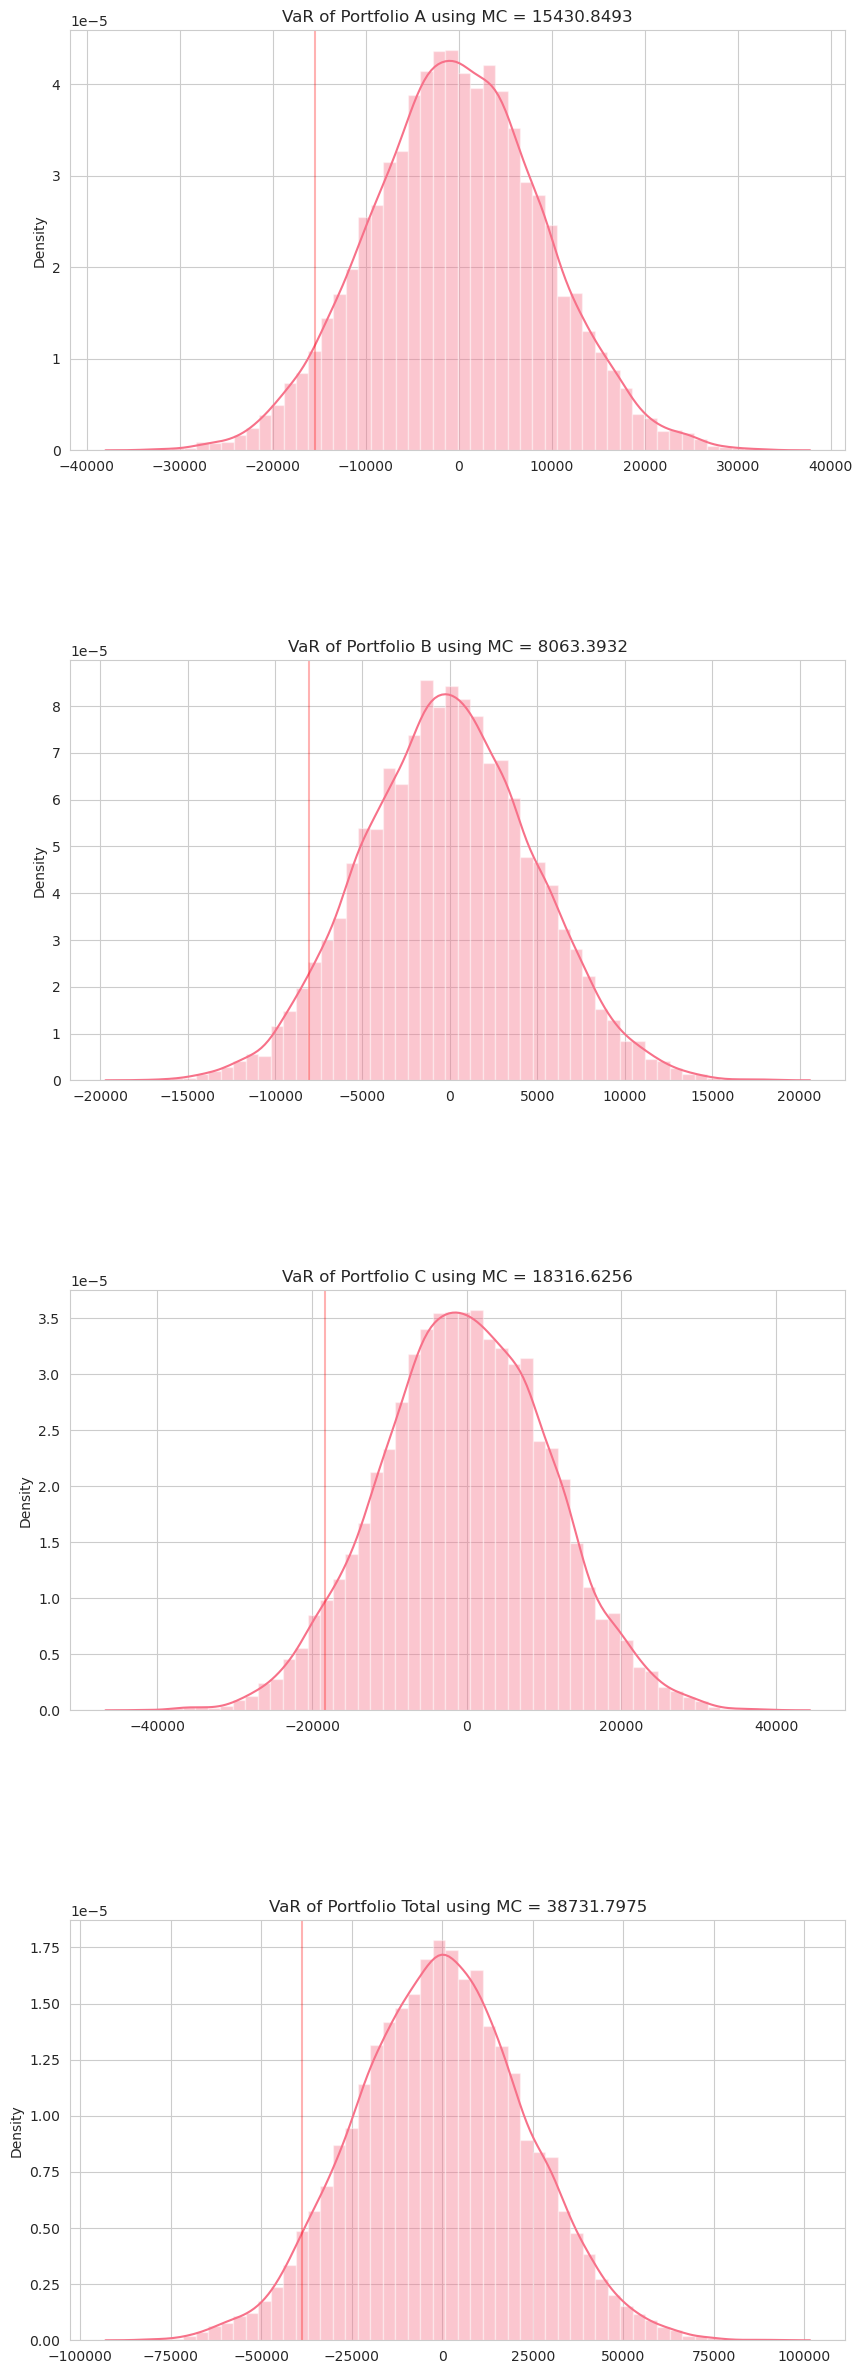

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, normaltest

portfolio = pd.read_csv('portfolio.csv')
prices = pd.read_csv('DailyPrices.csv')

def process_portfolio_data(portfolio, prices, p_type):
    if p_type == "total":
        co_assets = portfolio.drop('Portfolio', axis = 1)
        co_assets = co_assets.groupby(["Stock"], as_index=False)["Holding"].sum()
    else:
        co_assets = portfolio[portfolio['Portfolio'] == p_type]
    dailyprices = pd.concat([prices["Date"], prices[co_assets["Stock"]]], axis=1)

    holdings = co_assets['Holding']

    portfolio_price = np.dot(prices[co_assets["Stock"]].tail(1), co_assets['Holding'])

    return portfolio_price, dailyprices, holdings

def expo_weighted_cov(ret_data,w_lambda):
    weight = np.zeros(len(ret_data))
    for i in range(len(ret_data)):
        weight[len(ret_data)-1-i]  = (1-w_lambda)*w_lambda**i
    weight = weight/sum(weight)
    ret_means = ret_data - ret_data.mean()
    expo_w_cov = ret_means.T.values @ np.diag(weight) @ ret_means.values
    return expo_w_cov

# Use PCA simulation with 100% variance explianed
def pca_sim(cov_mtx, n_draws, percent_explain = 1):
    eigenvalues, eigenvectors = np.linalg.eig(cov_mtx)
    #Keep those positive eigenvalues and corresponding eigenvectors
    p_idx = eigenvalues > 1e-8
    eigenvalues = eigenvalues[p_idx]
    eigenvectors = eigenvectors[:, p_idx]
    #Sort
    s_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[s_idx]
    eigenvectors = eigenvectors[:, s_idx]

    if percent_explain == 1.0:
        percent_explain = (np.cumsum(eigenvalues)/np.sum(eigenvalues))[-1]

    n_eigenvalues = np.where((np.cumsum(eigenvalues)/np.sum(eigenvalues))>= percent_explain)[0][0] + 1
    #print(n_eigenvalues)
    eigenvectors = eigenvectors[:,:n_eigenvalues]
    eigenvalues = eigenvalues[:n_eigenvalues]
    std_normals = np.random.normal(size=(n_eigenvalues, n_draws))

    B = eigenvectors.dot(np.diag(np.sqrt(eigenvalues)))
    return np.transpose(B.dot(std_normals))

def cal_MC_var(portfolio, prices, p_type, alpha=0.05, w_lambda=0.94, N = 10000):
    portfolio_price, dailyprices, holding = process_portfolio_data(portfolio, prices, p_type)
    returns = return_calculate(dailyprices).drop('Date',axis=1)
    returns_0 = returns - returns.mean()

    np.random.seed(0)
    cov_mtx = expo_weighted_cov(returns_0, w_lambda)
    sim_ret = pca_sim(cov_mtx, N)
    dailyprices = np.add(dailyprices.drop('Date', axis=1), returns.mean().values)
    sim_change = np.dot(sim_ret * dailyprices.tail(1).values.reshape(dailyprices.shape[1]),holding)

    var = np.percentile(sim_change, alpha*100) * (-1)
    return var, sim_change

# Monte Carlo Simulation VaR
def return_calculate(data, method="discrete", datecol="Date"):
    # This function is similar to the return_cal function provided earlier.
    # Check if there is a date column in the data file
    vars = data.columns
    assert datecol in vars
    nvars = len(vars) - 1
    vars = list(vars)
    vars.pop(vars.index(datecol))
    
    prices = data.iloc[:, data.columns.get_loc(datecol)+1:]
    returns = np.zeros(shape=(len(prices)-1, nvars))
    returns = pd.DataFrame(returns)
    
    for i in range(len(prices)-1):
        for j in range(nvars):
            returns.iloc[i,j] = prices.iloc[i+1,j] / prices.iloc[i,j]
            if method == "discrete":
                returns.iloc[i,j] -= 1
            elif method == "log":
                returns.iloc[i,j] = np.log(returns.iloc[i,j])
            else:
                return sys.exit(1)
                
    dates = data.iloc[:, data.columns.get_loc(datecol)]
    dates = dates.drop(index=0)
    dates.index -= 1
    out = pd.DataFrame({datecol: dates})
    
    for i in range(nvars):
        out[vars[i]] = returns.iloc[:, i]
    return out

# Calculate VaR using Monte Carlo Simulation
MC_var_A, MC_dis_A = cal_MC_var(portfolio, prices, "A")
MC_var_B, MC_dis_B = cal_MC_var(portfolio, prices, "B")
MC_var_C, MC_dis_C = cal_MC_var(portfolio, prices, "C")
MC_var_T, MC_dis_T = cal_MC_var(portfolio, prices, "total")

# Plotting
fig, axes = plt.subplots(4, 1, figsize=(10, 30))
sns.distplot(MC_dis_A, ax=axes[0])
sns.distplot(MC_dis_B, ax=axes[1])
sns.distplot(MC_dis_C, ax=axes[2])
sns.distplot(MC_dis_T, ax=axes[3])

axes[0].axvline(x=-MC_var_A, color='red', alpha=0.3)
axes[1].axvline(x=-MC_var_B, color='red', alpha=0.3)
axes[2].axvline(x=-MC_var_C, color='red', alpha=0.3)
axes[3].axvline(x=-MC_var_T, color='red', alpha=0.3)

axes[0].set_title("VaR of Portfolio A using MC = {}".format(MC_var_A.round(4)))
axes[1].set_title("VaR of Portfolio B using MC = {}".format(MC_var_B.round(4)))
axes[2].set_title("VaR of Portfolio C using MC = {}".format(MC_var_C.round(4)))
axes[3].set_title("VaR of Portfolio Total using MC = {}".format(MC_var_T.round(4)))
plt.subplots_adjust(hspace=0.5)
plt.show()

In [30]:
# Define Delta-Normal VaR function
from scipy.stats import norm

def cal_delta_var(portfolio, prices, p_type, alpha=0.05, w_lambda=0.94, N = 10000):
    portfolio_price, dailyprices, holding = process_portfolio_data(portfolio, prices, p_type)
    returns = return_calculate(dailyprices).drop('Date',axis=1)
    dailyprices = dailyprices.drop('Date', axis=1)
    dR_dr = (dailyprices.tail(1).T.values * holding.values.reshape(-1, 1)) / portfolio_price
    cov_mtx = expo_weighted_cov(returns, w_lambda)
    R_std = np.sqrt(np.transpose(dR_dr) @ cov_mtx @ dR_dr)
    var = (-1) * portfolio_price * norm.ppf(alpha) * R_std
    return var[0][0]

# Calculate VaR using Delta-Normal Method
delta_var_A = cal_delta_var(portfolio, prices, "A")
delta_var_B = cal_delta_var(portfolio, prices, "B")
delta_var_C = cal_delta_var(portfolio, prices, "C")
delta_var_T = cal_delta_var(portfolio, prices, "total")

delta_var_A, delta_var_B, delta_var_C, delta_var_T


(15426.96801701297, 8082.57240228439, 18163.291619061267, 38941.3757289016)

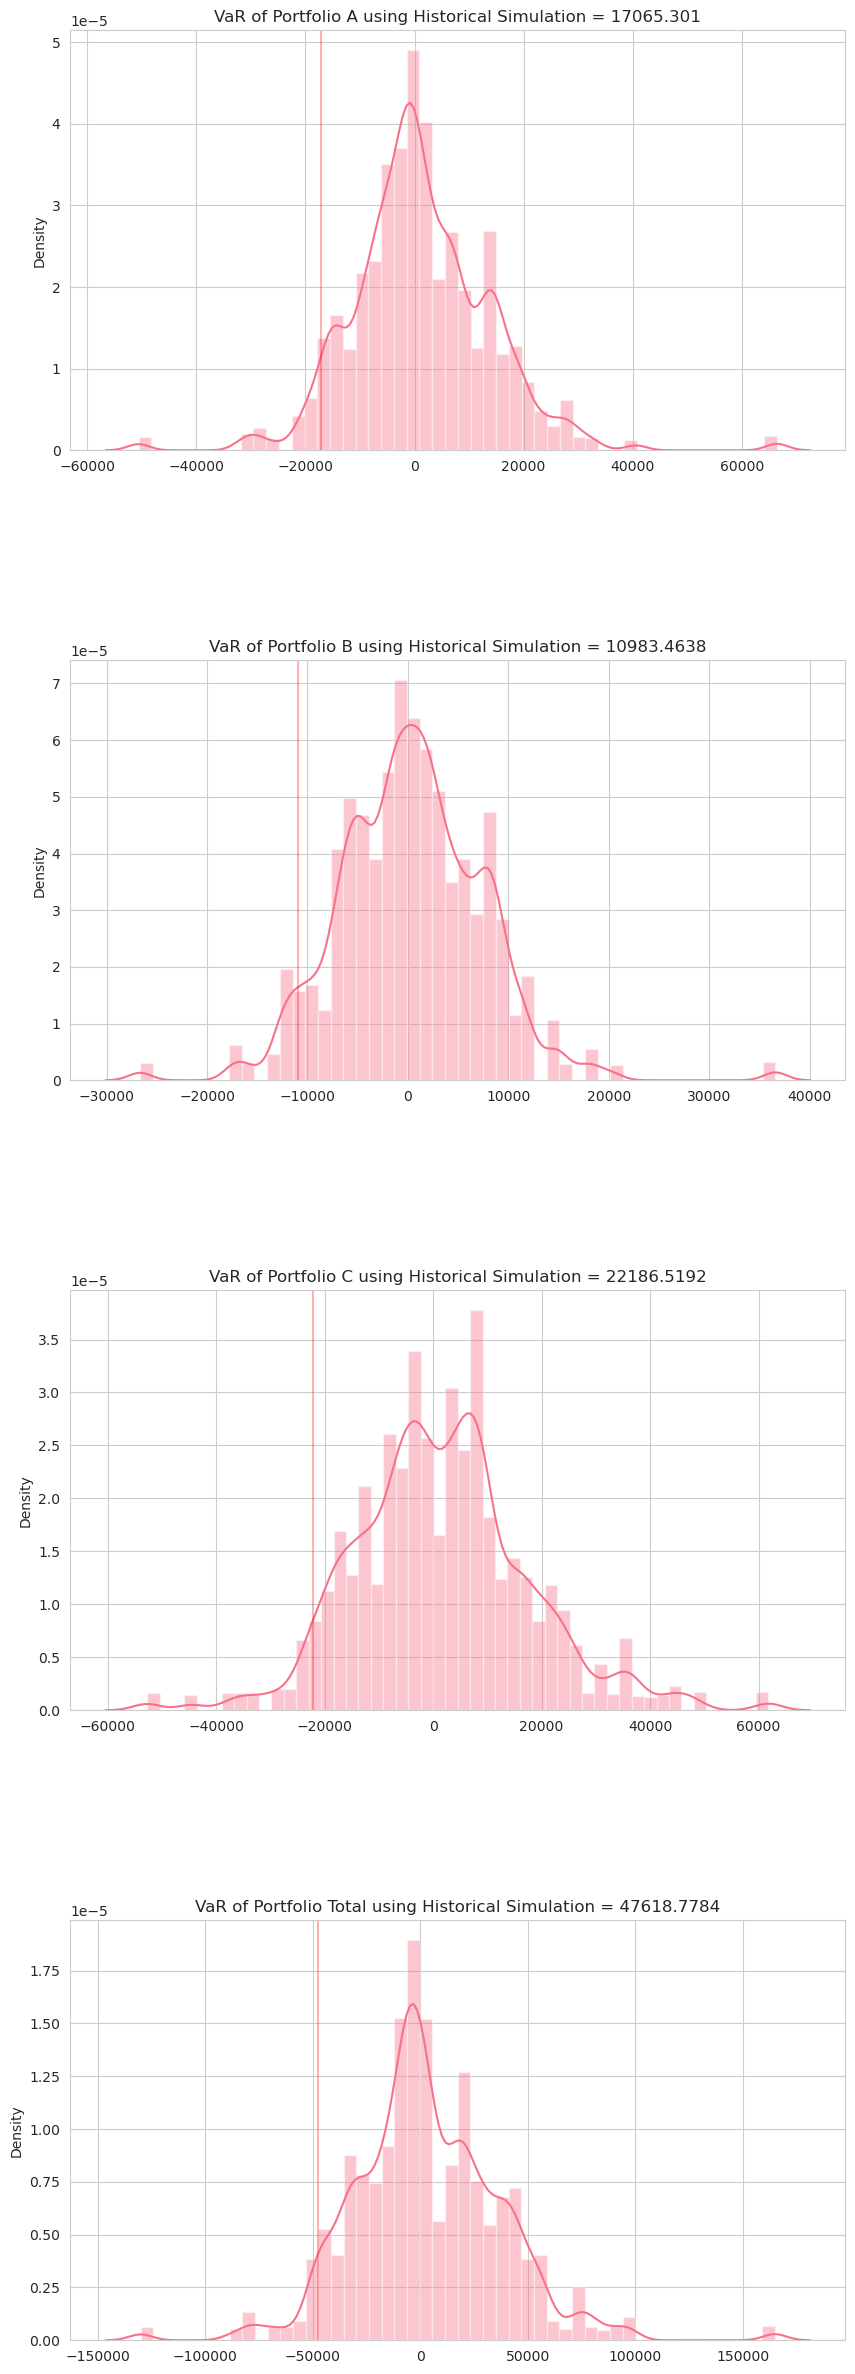

In [32]:
#Calculate VaR using historic simulation
def cal_his_var(portfolio, prices, p_type, alpha=0.05, N = 10000):
    portfolio_price, dailyprices, holding = process_portfolio_data(portfolio, prices, p_type)
    returns = return_calculate(dailyprices).drop('Date',axis=1)
    np.random.seed(0)
    sim_ret = returns.sample(N, replace=True)
    dailyprices = dailyprices.drop('Date', axis=1)
    sim_change = np.dot(sim_ret * dailyprices.tail(1).values.reshape(dailyprices.shape[1]),holding)

    var = np.percentile(sim_change, alpha*100) * (-1)
    return var, sim_change

# Calculate VaR using Historical Simulation
his_var_A, his_dis_A = cal_his_var(portfolio, prices, "A")
his_var_B, his_dis_B = cal_his_var(portfolio, prices, "B")
his_var_C, his_dis_C = cal_his_var(portfolio, prices, "C")
his_var_T, his_dis_T = cal_his_var(portfolio, prices, "total")

# Plotting
fig, axes = plt.subplots(4, 1, figsize=(10, 30))
sns.distplot(his_dis_A, ax=axes[0])
sns.distplot(his_dis_B, ax=axes[1])
sns.distplot(his_dis_C, ax=axes[2])
sns.distplot(his_dis_T, ax=axes[3])

axes[0].axvline(x=-his_var_A, color='red', alpha=0.3)
axes[1].axvline(x=-his_var_B, color='red', alpha=0.3)
axes[2].axvline(x=-his_var_C, color='red', alpha=0.3)
axes[3].axvline(x=-his_var_T, color='red', alpha=0.3)

axes[0].set_title("VaR of Portfolio A using Historical Simulation = {}".format(his_var_A.round(4)))
axes[1].set_title("VaR of Portfolio B using Historical Simulation = {}".format(his_var_B.round(4)))
axes[2].set_title("VaR of Portfolio C using Historical Simulation = {}".format(his_var_C.round(4)))
axes[3].set_title("VaR of Portfolio Total using Historical Simulation = {}".format(his_var_T.round(4)))
plt.subplots_adjust(hspace=0.5)
plt.show()

In [33]:
#Calculate VaR using Delta Normal
def cal_delta_var(portfolio, prices, p_type, alpha=0.05, w_lambda=0.94, N = 10000):
    portfolio_price, dailyprices, holding = process_portfolio_data(portfolio, prices, p_type)

    returns = return_calculate(dailyprices).drop('Date',axis=1)
    dailyprices = dailyprices.drop('Date', axis=1)
    dR_dr = (dailyprices.tail(1).T.values * holding.values.reshape(-1, 1)) / portfolio_price
    cov_mtx = expo_weighted_cov(returns, w_lambda)
    R_std = np.sqrt(np.transpose(dR_dr) @ cov_mtx @ dR_dr)
    var = (-1) * portfolio_price * norm.ppf(alpha) * R_std
    return var[0][0]

# Calculate VaR using Delta-Normal Method
delta_var_A = cal_delta_var(portfolio, prices, "A")
delta_var_B = cal_delta_var(portfolio, prices, "B")
delta_var_C = cal_delta_var(portfolio, prices, "C")
delta_var_T = cal_delta_var(portfolio, prices, "total")

delta_var_A, delta_var_B, delta_var_C, delta_var_T

(15426.96801701297, 8082.57240228439, 18163.291619061267, 38941.3757289016)

In [35]:
# Define the portfolios
portfolios = ['A', 'B', 'C', 'Total']

# Define the VaR values from each method
monte_carlo_values = [MC_var_A, MC_var_B, MC_var_C, MC_var_T]
historical_sim_values = [his_var_A, his_var_B, his_var_C, his_var_T]
delta_normal_values = [delta_var_A, delta_var_B, delta_var_C, delta_var_T]

# Create the summary table using pandas
summary_table = pd.DataFrame({
    'Portfolio': portfolios,
    'Monte Carlo': monte_carlo_values,
    'Historical Simulation': historical_sim_values,
    'Delta-Normal': delta_normal_values
})

# Print the table
print(summary_table.to_string(index=False))

Portfolio  Monte Carlo  Historical Simulation  Delta-Normal
        A 15430.849312           17065.300954  15426.968017
        B  8063.393224           10983.463847   8082.572402
        C 18316.625616           22186.519226  18163.291619
    Total 38731.797514           47618.778376  38941.375729
